In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC

import lifelines

In [2]:
# reading dataset from CSV file
cc_df = pd.read_csv("../data/UCI_Credit_Card.csv")

In [3]:
pd.DataFrame(cc_df["default.payment.next.month"].value_counts())
new_df = cc_df.rename(columns={"default.payment.next.month":'default'})

new_df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [4]:
categorical_feats = [
    'MARRIAGE',
    'EDUCATION'
]

numeric_feats = [
    'LIMIT_BAL',
    'BILL_AMT1',
    'BILL_AMT2',
    'BILL_AMT3',
    'BILL_AMT4',
    'BILL_AMT5',
    'BILL_AMT6',
    'PAY_AMT1',
    'PAY_AMT2',
    'PAY_AMT3',
    'PAY_AMT4',
    'PAY_AMT5',
    'PAY_AMT6',
    'PAY_0',
    'PAY_2',
    'PAY_3',
    'PAY_4',
    'PAY_5',
    'PAY_6',
    'AGE',
    'SEX'
]

drop_feats = [
]

passthrough_feats = [

]
target_column = ['default']

In [5]:
preprocessing_final = make_column_transformer(
    (
        FunctionTransformer(lambda x: x == 1),
        target_column,
    ),  # because we need it in this format for lifelines package
    ("passthrough", numeric_feats),
    # (StandardScaler(), numeric_feats),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_feats),
    ("drop", drop_feats),
)


In [6]:
train_df, test_df = train_test_split(new_df, random_state=123)

In [7]:
preprocessing_final.fit(train_df)

ColumnTransformer(transformers=[('functiontransformer',
                                 FunctionTransformer(func=<function <lambda> at 0x000001F9C53F5310>),
                                 ['default']),
                                ('passthrough', 'passthrough',
                                 ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6', 'PAY_0', 'PAY_2', 'PAY_3',
                                  'PAY_4', 'PAY_5', 'PAY_6', 'AGE', 'SEX']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['MARRIAGE', 'EDUCATION']),
                                ('drop', 'drop', [

In [8]:
new_columns = (
    target_column
    + passthrough_feats
    + numeric_feats
    + preprocessing_final.named_transformers_["onehotencoder"]
    .get_feature_names(categorical_feats)
    .tolist()
)

In [9]:

train_df_surv = pd.DataFrame(
    preprocessing_final.transform(train_df), index=train_df.index, columns=new_columns
)
test_df_surv = pd.DataFrame(
    preprocessing_final.transform(test_df), index=test_df.index, columns=new_columns
)

In [10]:
train_df_surv.describe()

,default,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6
count,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.00000,22500.000000,2.250000e+04,...,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.00000,22500.000000,22500.000000,22500.000000,22500.000000
mean,0.222622,167912.608000,51055.337244,49041.264133,46961.377200,43389.790578,40363.350933,38763.81320,5673.348800,5.926811e+03,...,0.453911,0.533778,0.010756,0.000489,0.353556,0.46760,0.163378,0.003689,0.009689,0.001600
std,0.416016,130144.258317,73210.223674,71131.003713,68802.264441,64599.545694,61009.524485,59457.26977,16916.734372,2.151420e+04,...,0.497882,0.498869,0.103152,0.022106,0.478084,0.49896,0.369718,0.060625,0.097956,0.039969
min,0.000000,10000.000000,-15308.000000,-67526.000000,-157264.000000,-65167.000000,-61372.000000,-339603.00000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,50000.000000,3613.750000,2916.000000,2680.750000,2293.750000,1727.750000,1200.00000,1000.000000,8.240000e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,140000.000000,22339.000000,21052.500000,20089.000000,19067.500000,18043.500000,16855.00000,2100.000000,2.011000e+03,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,240000.000000,66923.500000,63611.750000,60016.250000,54603.000000,50398.500000,49276.25000,5011.000000,5.000000e+03,...,1.000000,1.000000,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1000000.000000,964511.000000,983931.000000,855086.000000,891586.000000,927171.000000,961664.00000,873552.000000,1.227082e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [82]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(train_df_surv["AGE" ], train_df_surv["default"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 22500 total observations, 17491 right-censored observations>

Text(0, 0.5, 'Survival probability')

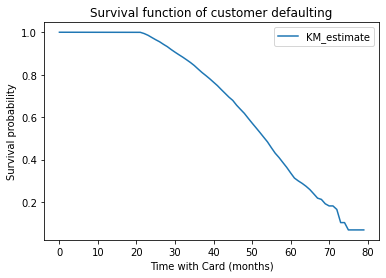

In [83]:
kmf.survival_function_.plot()
plt.title("Survival function of customer defaulting")
plt.xlabel("Time with Card (months)")
plt.ylabel("Survival probability")

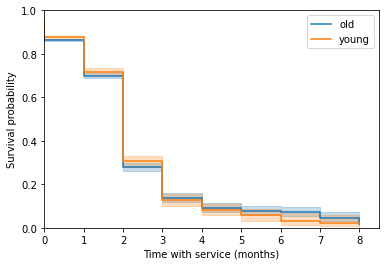

In [87]:
T = train_df_surv["PAY_0"]
E = train_df_surv["default"]


old = train_df_surv["AGE"] > 30
E = train_df_surv["default"]
ax = plt.subplot(111)

kmf.fit(T[old], event_observed=E[old], label="old")
kmf.plot(ax=ax)

kmf.fit(T[~old], event_observed=E[~old], label="young")
kmf.plot(ax=ax)

plt.ylim(0, 1)
plt.xlim(0)
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

In [90]:
cph = lifelines.CoxPHFitter(penalizer=0.1)
cph.fit(train_df_surv, duration_col="PAY_6", event_col="default")

<lifelines.CoxPHFitter: fitted with 22500 total observations, 17491 right-censored observations>

In [91]:
cph_params = pd.DataFrame(cph.params_).sort_values(by="coef", ascending=False)
cph_params

,coef
covariate,
PAY_0,2.231621e-01
MARRIAGE_1,6.012026e-02
EDUCATION_1,4.073672e-02
PAY_2,2.965466e-02
EDUCATION_3,1.582826e-02
AGE,3.284306e-03
PAY_AMT5,1.111319e-06
LIMIT_BAL,-5.653491e-08
BILL_AMT2,-1.130511e-07


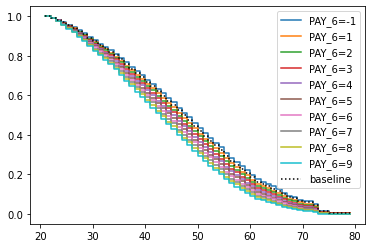

In [89]:

cph.plot_partial_effects_on_outcome("PAY_6", [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]);

In [80]:
cph.predict_expectation(test_df_surv)

25665    27.432136
16464    37.105877
22386    18.320082
10149    42.272494
8729     31.559348
           ...    
10481    37.271849
1689     37.857848
7370     31.381005
4608     18.250650
28474    26.363876
Length: 7500, dtype: float64

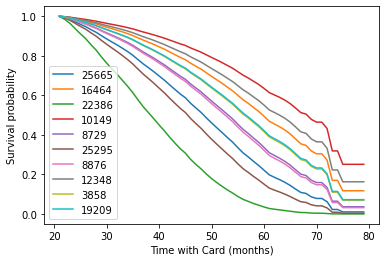

In [81]:
cph.predict_survival_function(test_df_surv[:10]).plot()
plt.xlabel("Time with Card (months)")
plt.ylabel("Survival probability");

In [75]:
cph.score(train_df_surv, scoring_method="concordance_index")


0.7319300424728318

In [76]:
cph.score(test_df_surv, scoring_method="concordance_index")

0.7360632204648014